# Predicting a 'no show' for a medical appointment based on historical data
This notebook uses a historical dataset from 2016 to predict someone not showing up for a medical appointment.
## Packages
The following packages were used.

In [567]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


## Data input
First the dataset was read in.

In [503]:
df = pd.read_csv('data/medical_no_show.csv')
print('Count of rows', str(df.shape[0]))
print('Count of Columns', str(df.shape[1]))
df.head()

Count of rows 110527
Count of Columns 14


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In the next part we check for missing data.

In [504]:
df.isnull().any().any()

False

As no missing data was found, we proceeded with verifying the dtypes for each of the columns.

In [505]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

Furthermore, we check how many unique values there are for each column.

In [506]:
for i in df.columns:
    print(i+":",len(df[i].unique()))

PatientId: 62299
AppointmentID: 110527
Gender: 2
ScheduledDay: 103549
AppointmentDay: 27
Age: 104
Neighbourhood: 81
Scholarship: 2
Hipertension: 2
Diabetes: 2
Alcoholism: 2
Handcap: 5
SMS_received: 2
No-show: 2


## Data Cleaning
First all column names are converted lowercase to achieve consistency.

In [507]:
df.columns = df.columns.str.lower().str.strip()

The `appointmentid` is set as index for the dataset.

In [508]:
df.set_index('appointmentid', inplace = True)

`patientid` needs to be converted to `int`.  
`no-show` needs to be converted to `int`.  
`gender` needs to be converted to `int`.  

In [509]:
df['patientid'] = df['patientid'].astype('int64')
df['no-show'] = df['no-show'].map({'No':0, 'Yes':1})
df['gender'] = df['gender'].map({'F':0, 'M':1})

The following code allows for the inclusion of `neighbourhood` is converted using one hot encoding. However, due to little value and overcomplication of the model, this variable was not included further down the line.

In [510]:
# df = pd.get_dummies(df, columns = ['neighbourhood'])
# df.columns = df.columns.str.lower().str.strip()

A couple of features were added:
- `num_app`: count how many previous appointments the patient has had (starting with 0)
- `apps_missed`: number of appointments missed previously
- `previous_noshow`: percentage of previously missed appointments

In [511]:
df['num_app'] = df.sort_values(by = ['patientid','scheduledday']).groupby(['patientid']).cumcount() + 1
df['apps_missed'] = df.sort_values(by = ['patientid','scheduledday']).groupby(['patientid'])['no-show'].cumsum().shift(1, axis = 0)
df['noshow_pct'] = df['apps_missed'] / (df.sort_values(by = ['patientid','scheduledday']).groupby(['patientid'])['num_app'].shift(1, axis =0))
df['noshow_pct'].fillna(0, inplace = True)
df['apps_missed'].fillna(0, inplace = True)

Below is an example of a patient that has had multiple appointments and missed some as well.

In [512]:
df[df['patientid'] == 838284762259].sort_values(by = ['patientid','scheduledday'])[['scheduledday', 'no-show', 'num_app', 'noshow_pct', 'apps_missed']]

,scheduledday,no-show,num_app,noshow_pct,apps_missed
appointmentid,,,,,
5566277,2016-04-11T10:09:42Z,0,1,0.000000,0.0
5640434,2016-04-29T10:43:19Z,0,2,0.000000,0.0
5640443,2016-04-29T10:44:22Z,1,3,0.000000,0.0
5653643,2016-05-03T12:59:01Z,0,4,0.333333,1.0
5674766,2016-05-09T11:52:43Z,1,5,0.250000,1.0
5685329,2016-05-11T10:10:16Z,0,6,0.400000,2.0
5685501,2016-05-11T10:30:03Z,0,7,0.333333,2.0
5716528,2016-05-18T17:48:31Z,0,8,0.285714,2.0
5716529,2016-05-18T17:48:31Z,0,9,0.250000,2.0


Convert `scheduledday` and `appointmentday` to the datetime format.

In [513]:
df['scheduledday'] = pd.to_datetime(df['scheduledday']).dt.strftime('%Y-%m-%d')
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday']).dt.strftime('%Y-%m-%d')
df['appointmentday'] = pd.to_datetime(df['appointmentday'])

Calculate the difference between the day that the appointment was scheduled and when the appointment actually occurred.  
Next we filter out those that have a difference less than zero, as this is likely erroneous data where the appointment occurred before the scheduled date.  
Also, people with an age lower or equal to 0 are filtered out, as these are likely wrong entries.

In [514]:
df['day_diff'] = (df['appointmentday'] - df['scheduledday']).dt.days
# Filter by day_diff
df = df[df['day_diff'] >= 0]
# Filter by age
df = df[df['age'] > 0]

Dummy variables are generated for `handcap` in the next step.

In [515]:
# Convert to Categorical
df['handcap'] = pd.Categorical(df['handcap'])
# Convert to Dummy Variables
Handicap = pd.get_dummies(df['handcap'], prefix = 'handicap')
df = pd.concat([df, Handicap], axis=1)

Unnecessary columns are subsequently dropped.

In [516]:
df.drop(['scheduledday'], axis=1, inplace=True)
df.drop(['appointmentday'], axis=1, inplace=True)
df.drop(['handcap'], axis=1, inplace = True)
df.drop(['neighbourhood'], axis=1, inplace = True)

## Exploratory analysis

## Machine learning

A random seed was set to ensure reproducability of the data.

In [517]:
np.random.seed(123)

80% of the time people did show up for an appointment, leading to an inbalanced dataset.  
Just always predicting 0, therefore already leads to an accuracy of 80%, making this scoring parameter not very useful.  
As we are more interested in the positive class, average precision and f1 scores will be used to evaluate different models.

In [518]:
df['no-show'].value_counts(normalize=True)

0    0.797396
1    0.202604
Name: no-show, dtype: float64

Scaling of the data occurred using a robust scaler, after removing some columns irrelevant for training.

In [539]:
X = df.drop(['no-show', 'patientid'], axis=1)
y = df['no-show']
scaler = RobustScaler()
X = scaler.fit_transform(X)

Next the dataset is split into a training and test set after shuffling and stratification.  
To increase the importance of the positive class, upsampling of this class was done using SMOTE (Synthetic Minority Oversampling technique).

In [550]:
sm = SMOTE(random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify = y, test_size = 0.3, random_state=123)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [551]:
lr = LogisticRegression(solver='newton-cg',)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_train)

avg_f1 = cross_val_score(estimator = lr, X = X_train, y =y_train, cv = 10, scoring='f1')
print("avg f1: ", np.mean(avg_f1))
print("std f1: ", np.std(avg_f1))

avg precision:  0.6146347402735074
std precision:  0.0018194094885900743


In [552]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_train)

avg_f1 = cross_val_score(estimator = knn, X = X_train, y =y_train, cv = 10, scoring='f1')
print("avg f1: ", np.mean(avg_f1))
print("std f1: ", np.std(avg_f1))

avg precision:  0.761949007566662
std precision:  0.013301899037296065


In [553]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_train)
clf_report = classification_report(y_train, y_pred_dtc)

avg_f1 = cross_val_score(estimator = dtc, X = X_train, y =y_train, cv = 10, scoring='f1')
print("avg f1: ", np.mean(avg_f1))
print("std f1: ", np.std(avg_f1))

avg precision:  0.7726162133466541
std precision:  0.15745719082806495


In [524]:
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, y_train)

y_pred_rd_clf = rd_clf.predict(X_train)
clf_report = classification_report(y_train, y_pred_rd_clf)

avg_f1 = cross_val_score(estimator = rd_clf, X = X_train, y =y_train, cv = 10, scoring='f1')
print("avg f1: ", np.mean(avg_f1))
print("std f1: ", np.std(avg_f1))

avg precision:  0.8007910947163431
std precision:  0.09176857329122966


In [525]:
ada = AdaBoostClassifier(base_estimator = dtc)
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_train)
clf_report = classification_report(y_train, y_pred_ada)

avg_f1 = cross_val_score(estimator = ada, X = X_train, y =y_train, cv = 10, scoring='f1')
print("avg f1: ", np.mean(avg_f1))
print("std f1: ", np.std(avg_f1))

avg precision:  0.7877334676202021
std precision:  0.14831277439696502


In [563]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_train)
clf_report = classification_report(y_train, y_pred_xgb)

avg_f1 = cross_val_score(estimator = xgb, X = X_train, y =y_train, cv = 10, scoring='f1')
print("avg f1: ", np.mean(avg_f1))
print("std f1: ", np.std(avg_f1))

avg precision:  0.7599662564428785
std precision:  0.2738144481417969


The random forest classifier seem to be performing the best.  
For this reason hyperparameter optimization was done on this model, using Bayesian search, using the f1 score to fit the parameters in order to focus more on the positive event.

In [587]:
# Model parameters
from random import random

max_depth = list(np.arange(10,500, 10))
max_depth.append(None)
n_estimators = list(np.arange(10,200, 10))
criterion = ['gini', 'entropy']
max_features = list(np.arange(5,50, 5))
max_features.append(None)
max_leaf_nodes = list(np.arange(4,100, 2))
max_leaf_nodes.append(None)
min_samples_split = list(np.arange(2,30, 2))
min_samples_split.append(None)

pipe = Pipeline([
    ('reg', RandomForestClassifier())
    ])
param_grid = [
    {
        'reg': [RandomForestClassifier(random_state = 123)],
        'reg__n_estimators': n_estimators,
        'reg__criterion': criterion,
        'reg__max_depth': max_depth,
        'reg__max_features': max_features,
        'reg__warm_start': [True], 
        'reg__min_samples_split': min_samples_split,
        'reg__n_jobs': [-1],
        'reg__max_leaf_nodes': max_leaf_nodes,
        'reg__bootstrap': [True]
    },
]
grid_pipeline = BayesSearchCV(pipe,param_grid, cv = KFold(10, random_state=123, shuffle = True), n_jobs=-1, n_iter=50, return_train_score=True, random_state = 123, scoring = 'f1')

In [588]:
grid_pipeline.fit(X_train,y_train)
best_model = grid_pipeline.best_estimator_
print('F1 score is: {}'.format(round(grid_pipeline.best_score_, 2)))

The following model resulted in the best score after using 10-fold crossvalidation:

In [596]:
print(grid_pipeline.best_params_)

OrderedDict([('reg', RandomForestClassifier(max_depth=30, max_features=40, max_leaf_nodes=94,
                       n_estimators=160, n_jobs=-1, random_state=123,
                       warm_start=True)), ('reg__bootstrap', True), ('reg__max_depth', 30), ('reg__max_features', 40), ('reg__max_leaf_nodes', 94), ('reg__n_estimators', 160), ('reg__n_jobs', -1), ('reg__warm_start', True)])


On the test set, the model performs as follows:

In [592]:
grid_pipeline_pred = grid_pipeline.predict(X_test)
clf_report = classification_report(y_test, grid_pipeline_pred)
print(f"Classification Report : \n{clf_report}")
print(f"Average precision is : {round(metrics.average_precision_score(y_test, grid_pipeline_pred), 2)}")

Classification Report : 
              precision    recall  f1-score   support

           0       0.86      0.77      0.81     25592
           1       0.37      0.52      0.43      6503

    accuracy                           0.72     32095
   macro avg       0.61      0.65      0.62     32095
weighted avg       0.76      0.72      0.74     32095

Average precision is : 0.29


ROC curves were subsequently generated to evaluate the performance of the model on both the training and the test set.

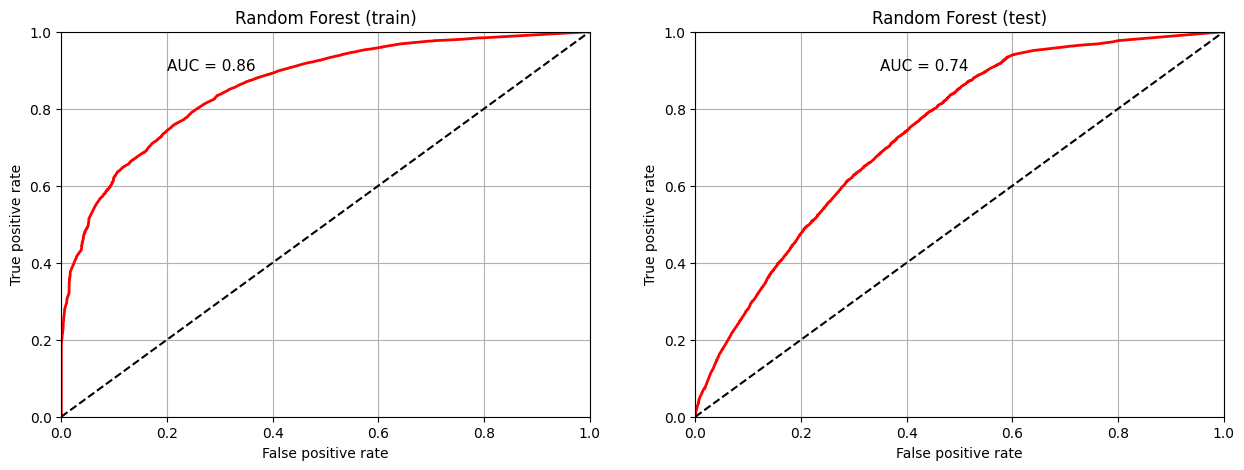

In [593]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))

pre_y_train = grid_pipeline.predict_proba(X_train)[:,1]
fpr_train, tpr_train, _ =metrics.roc_curve(y_train, pre_y_train)
aucval_train = metrics.auc(fpr_train, tpr_train)
ax1.plot(fpr_train, tpr_train,"r",linewidth = 2)
ax1.text(0.20,0.9,"AUC = "+str(round(aucval_train, 2)), size = 11)
ax1.set_title("Random Forest (train)")

pre_y_test = grid_pipeline.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ =metrics.roc_curve(y_test, pre_y_test)
aucval_test = metrics.auc(fpr_test, tpr_test)
ax2.plot(fpr_test, tpr_test,"r",linewidth = 2)
ax2.text(0.35,0.9,"AUC = "+str(round(aucval_test, 2)), size = 11)
ax2.set_title("Random Forest (test)")

for ax in [ax1, ax2]:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.grid()
    ax.set_xlabel ("False positive rate")
    ax.set_ylabel ("True positive rate")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    

To evaluate which features contributed most to a no-show, feature importance was extracted from the model.  
This showed that the biggest contributing factor was the difference between the date of scheduling and the date of the appointment. Other contributing factors were the age of the patient, if they had previously missed appointments or not and whether or not they received a text notification.

In [594]:
pd.DataFrame(np.round(best_model[0].feature_importances_,2), index =df.drop(['no-show', 'patientid'], axis=1).columns, columns=['importance']).sort_values('importance', ascending=False).sort_values(by='importance', ascending=False).head(20)

,importance
day_diff,0.75
age,0.18
noshow_pct,0.03
apps_missed,0.02
gender,0.01
num_app,0.01
scholarship,0.00
hipertension,0.00
diabetes,0.00
alcoholism,0.00
